### Compare HRRR-AK Data to the Powder Patch Meteorological Station Data 

Notebook contents 
* Load the cleaned up HRRR-AK Data, load the gridcell closest to Powder Patch and compare with the Met Station Data  

created by Cassie Lumbrazo\
last updated: April 2025\
run location: UAS linux\
python environment: **rasterio**

In [14]:
# import packages 
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import dates
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import scipy

from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import ticker

import rioxarray
import rasterio 
import cfgrib
import os

In [3]:
pwd

'/home/cassie/python/repos/snow_model_forcing'

## Load HRRR-AK Data

In [6]:
# load the netcdf 
# ds_hrrrak = xr.open_dataset('/hdd/snow_hydrology/hrrrak/netcdf/hrrrak_merged_grib_WY2024.nc') 
ds_hrrrak = xr.open_dataset('/hdd/snow_hydrology/hrrrak/netcdf/hrrrak_merged_grib_WY2025.nc') 
ds_hrrrak

<xarray.Dataset> Size: 110MB
Dimensions:       (time: 4368, y: 20, x: 21)
Coordinates:
  * time          (time) datetime64[ns] 35kB 2024-10-01T01:00:00 ... 2025-04-01
    step          (time) timedelta64[ns] 35kB ...
    valid_time    (time) datetime64[ns] 35kB ...
    latitude      (y, x) float64 3kB ...
    longitude     (y, x) float64 3kB ...
Dimensions without coordinates: y, x
Data variables: (12/15)
    temp_surface  (time, y, x) float32 7MB ...
    pressure      (time, y, x) float32 7MB ...
    precip_rate   (time, y, x) float32 7MB ...
    snowdepth     (time, y, x) float32 7MB ...
    orog          (time, y, x) float32 7MB ...
    precip_total  (time, y, x) float32 7MB ...
    ...            ...
    lwrad         (time, y, x) float32 7MB ...
    temp          (time, y, x) float32 7MB ...
    rh            (time, y, x) float32 7MB ...
    u10           (time, y, x) float32 7MB ...
    v10           (time, y, x) float32 7MB ...
    wind          (time, y, x) float32 7MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP

Assign a CRS, and select Powder Patch Gridcell

In [121]:
# Assign latitude and longitude as coordinates for y and x axes
ds_hrrrak = ds_hrrrak.assign_coords({"y": ds_hrrrak.latitude[:, 0], "x": ds_hrrrak.longitude[0, :]})

# Now, check the coordinates again to make sure they are assigned properly
print(ds_hrrrak.coords)

# Now assign the CRS with EPSG:4326 (assuming the lat/lon are in degrees)
ds_hrrrak.rio.write_crs("EPSG:4326", inplace=True)

ds_hrrrak.rio.crs

# Powder Patch Lat/Lon
lat_powderpatch = 58.26200
# lon_powderpatch = -134.51700
lon_powderpatch = 225.483 # for now, the lon is in 360-degree format, so we convert it to 225.483 

# select the nearest grid point to the given lat/lon
ds_hrrrak_pp = ds_hrrrak.sel(y=lat_powderpatch, x=lon_powderpatch, method='nearest') 

Coordinates:
  * time         (time) datetime64[ns] 35kB 2024-10-01T01:00:00 ... 2025-04-01
    step         (time) timedelta64[ns] 35kB ...
    valid_time   (time) datetime64[ns] 35kB 2024-10-01T01:00:00 ... 2025-04-01
    latitude     (y, x) float64 3kB ...
    longitude    (y, x) float64 3kB -134.9 -134.9 -134.8 ... -134.0 -133.9
    spatial_ref  int64 8B 0
  * y            (y) float64 160B 58.08 58.11 58.14 58.16 ... 58.54 58.56 58.59
  * x            (x) float64 168B -134.9 -134.9 -134.8 ... -134.0 -134.0 -133.9


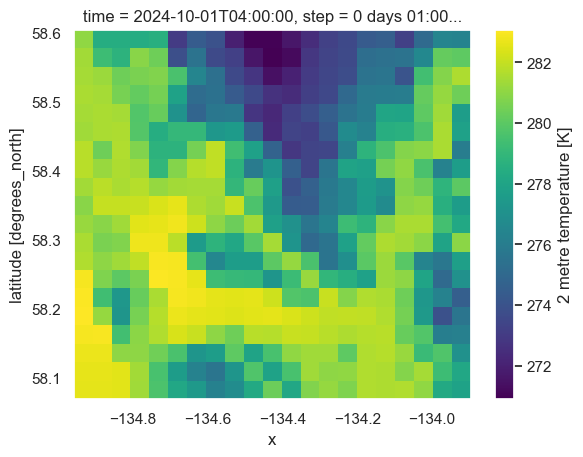

In [134]:
ds_hrrrak['temp'][3].plot()

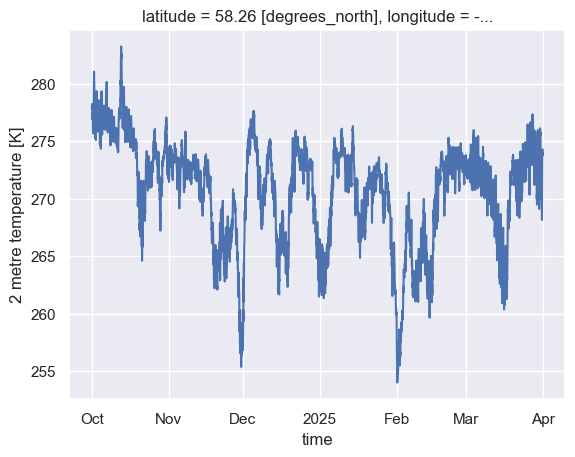

In [122]:
ds_hrrrak_pp['temp'].plot()

In [123]:
ds_hrrrak_pp

<xarray.Dataset> Size: 367kB
Dimensions:       (time: 4368)
Coordinates:
  * time          (time) datetime64[ns] 35kB 2024-10-01T01:00:00 ... 2025-04-01
    step          (time) timedelta64[ns] 35kB ...
    valid_time    (time) datetime64[ns] 35kB 2024-10-01T01:00:00 ... 2025-04-01
    latitude      float64 8B ...
    longitude     float64 8B -133.9
    y             float64 8B 58.27
    x             float64 8B -133.9
    spatial_ref   int64 8B 0
Data variables: (12/15)
    temp_surface  (time) float32 17kB ...
    pressure      (time) float32 17kB ...
    precip_rate   (time) float32 17kB ...
    snowdepth     (time) float32 17kB ...
    orog          (time) float32 17kB ...
    precip_total  (time) float32 17kB ...
    ...            ...
    lwrad         (time) float32 17kB ...
    temp          (time) float32 17kB ...
    rh            (time) float32 17kB ...
    u10           (time) float32 17kB ...
    v10           (time) float32 17kB ...
    wind          (time) float32 17kB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP

Also, we should consider the elevation of this gridcell...

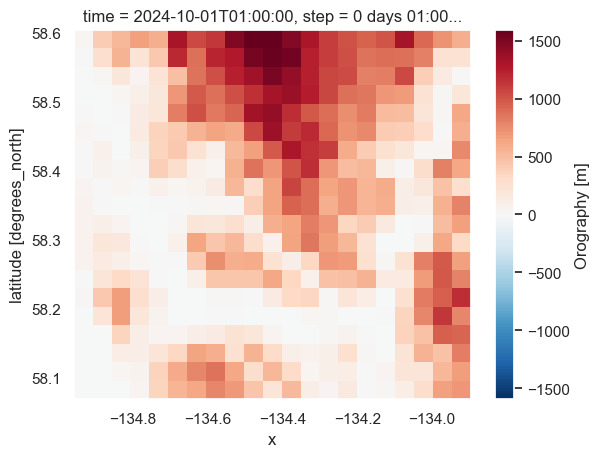

In [124]:
ds_hrrrak['orog'][0].plot()

The long was in 360 degree format instead of 180, but now it seems fixed? Just keep an eye on this when pulling a single location

In [110]:
# # longitude values are in 0 to 380 format instead of the -180 to 180 format. 
# # Convert longitude values from 0-360 to -180 to 180

# ds_hrrrak = ds_hrrrak.assign_coords(longitude=((ds_hrrrak.longitude + 180) % 360) - 180)
# ds_hrrrak['orog'][0].plot()

In [129]:
ds_hrrrak_pp['orog'].values[0]

np.float32(654.5822)

Powder Patch Met Station is at 2198 ft, 669.95 m so 654 m is not far off. 

## Load the Powder Patch Met Station Data 

In [5]:
# filename = '/home/cassie/data/fishcreek/mesonet/rawdata/DouglasIsland_AllStations_RawData_WY2024.txt'
filename = '/home/cassie/data/fishcreek/mesonet/rawdata/DouglasIsland_AllStations_RawData_WY2025_until16March2025.txt'

# open
df_met = pd.read_csv(filename, sep = ",")

# make utc_valid a datetime and index the df_met by it 
df_met['datetime'] = pd.to_datetime(df_met['utc_valid'])
df_met = df_met.set_index('datetime')
df_met.head()

,station,utc_valid,HGIRZZZ,PAIRZZZ,PCIRZZZ,PPDRZZZ,PPIRZZZ,PPPRZZZ,PPVRZZZ,PTIRZZZ,...,VVIRZZZ,VVPRZZZ,XCIRZZZ,XCPRZZZ,XPPRZZZ,XPQRZZZ,XRIRZZZ,XWIRZZZ,XWPRZZZ,sdIRZZZ
datetime,,,,,,,,,,,,,,,,,,,,,
2024-10-01 00:04:00,ECEA2,2024-10-01 00:04:00,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN
2024-10-01 00:09:00,ECEA2,2024-10-01 00:09:00,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN
2024-10-01 00:14:00,ECEA2,2024-10-01 00:14:00,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN
2024-10-01 00:19:00,ECEA2,2024-10-01 00:19:00,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN
2024-10-01 00:24:00,ECEA2,2024-10-01 00:24:00,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN


In [10]:
# light cleaning based on the first plot, just for the figure cleaning.. 
# drop PCIRZZZ values above 100 
df_met['PCIRZZZ'] = df_met['PCIRZZZ'].where(df_met['PCIRZZZ'] < 100) # only keep values less than 100

df_met['PPDRZZZ'] = df_met['PPDRZZZ'].where(df_met['PPDRZZZ'] > -100)
df_met['PPIRZZZ'] = df_met['PPIRZZZ'].where(df_met['PPIRZZZ'] > -100)
df_met['PPPRZZZ'] = df_met['PPPRZZZ'].where(df_met['PPPRZZZ'] > -100)
df_met['PPVRZZZ'] = df_met['PPVRZZZ'].where(df_met['PPVRZZZ'] > -100)


# drop any SDIRZZZ values above 100, for now 
df_met['SDIRZZZ'] = df_met['SDIRZZZ'].where(df_met['SDIRZZZ'] < 100)

In [11]:
# create a dataframe with individual observations of snow depth to then plot with the timeseries 
obs = {
    'datetime': ['2025-01-23', '2025-01-28', '2025-02-12', '2025-02-16', '2025-02-20', '2025-02-27', '2025-03-13'],
    'snowdepth': [126, 123, 133, 130, 128, 147, 177]
}

df_obs = pd.DataFrame(obs)
df_obs['datetime'] = pd.to_datetime(df_obs['datetime'])
df_obs.set_index('datetime', inplace=True)
# but keep datetime as a column too 
df_obs['datetime'] = df_obs.index
df_obs

,snowdepth,datetime
datetime,,
2025-01-23,126,2025-01-23
2025-01-28,123,2025-01-28
2025-02-12,133,2025-02-12
2025-02-16,130,2025-02-16
2025-02-20,128,2025-02-20
2025-02-27,147,2025-02-27
2025-03-13,177,2025-03-13


In [12]:
# lets only plot PPSA2 station data all together 
# create a new dataframe with only PPSA2 station data
df_met_pp = df_met[df_met['station'] == 'PPSA2']
# drop the columns where all the values are NaN
df_met_pp = df_met_pp.dropna(axis=1, how='all')
df_met_pp.head()

,station,utc_valid,PCIRZZZ,SDIRZZZ,TAIRZZZ,XRIRZZZ
datetime,,,,,,
2024-10-01 00:00:00,PPSA2,2024-10-01 00:00:00,NaN,16.97,39.2,81.6
2024-10-01 01:00:00,PPSA2,2024-10-01 01:00:00,NaN,16.58,39.3,85.1
2024-10-01 02:00:00,PPSA2,2024-10-01 02:00:00,NaN,16.88,39.3,86.2
2024-10-01 03:00:00,PPSA2,2024-10-01 03:00:00,NaN,16.18,38.3,90.0
2024-10-01 04:00:00,PPSA2,2024-10-01 04:00:00,NaN,17.19,37.5,92.3


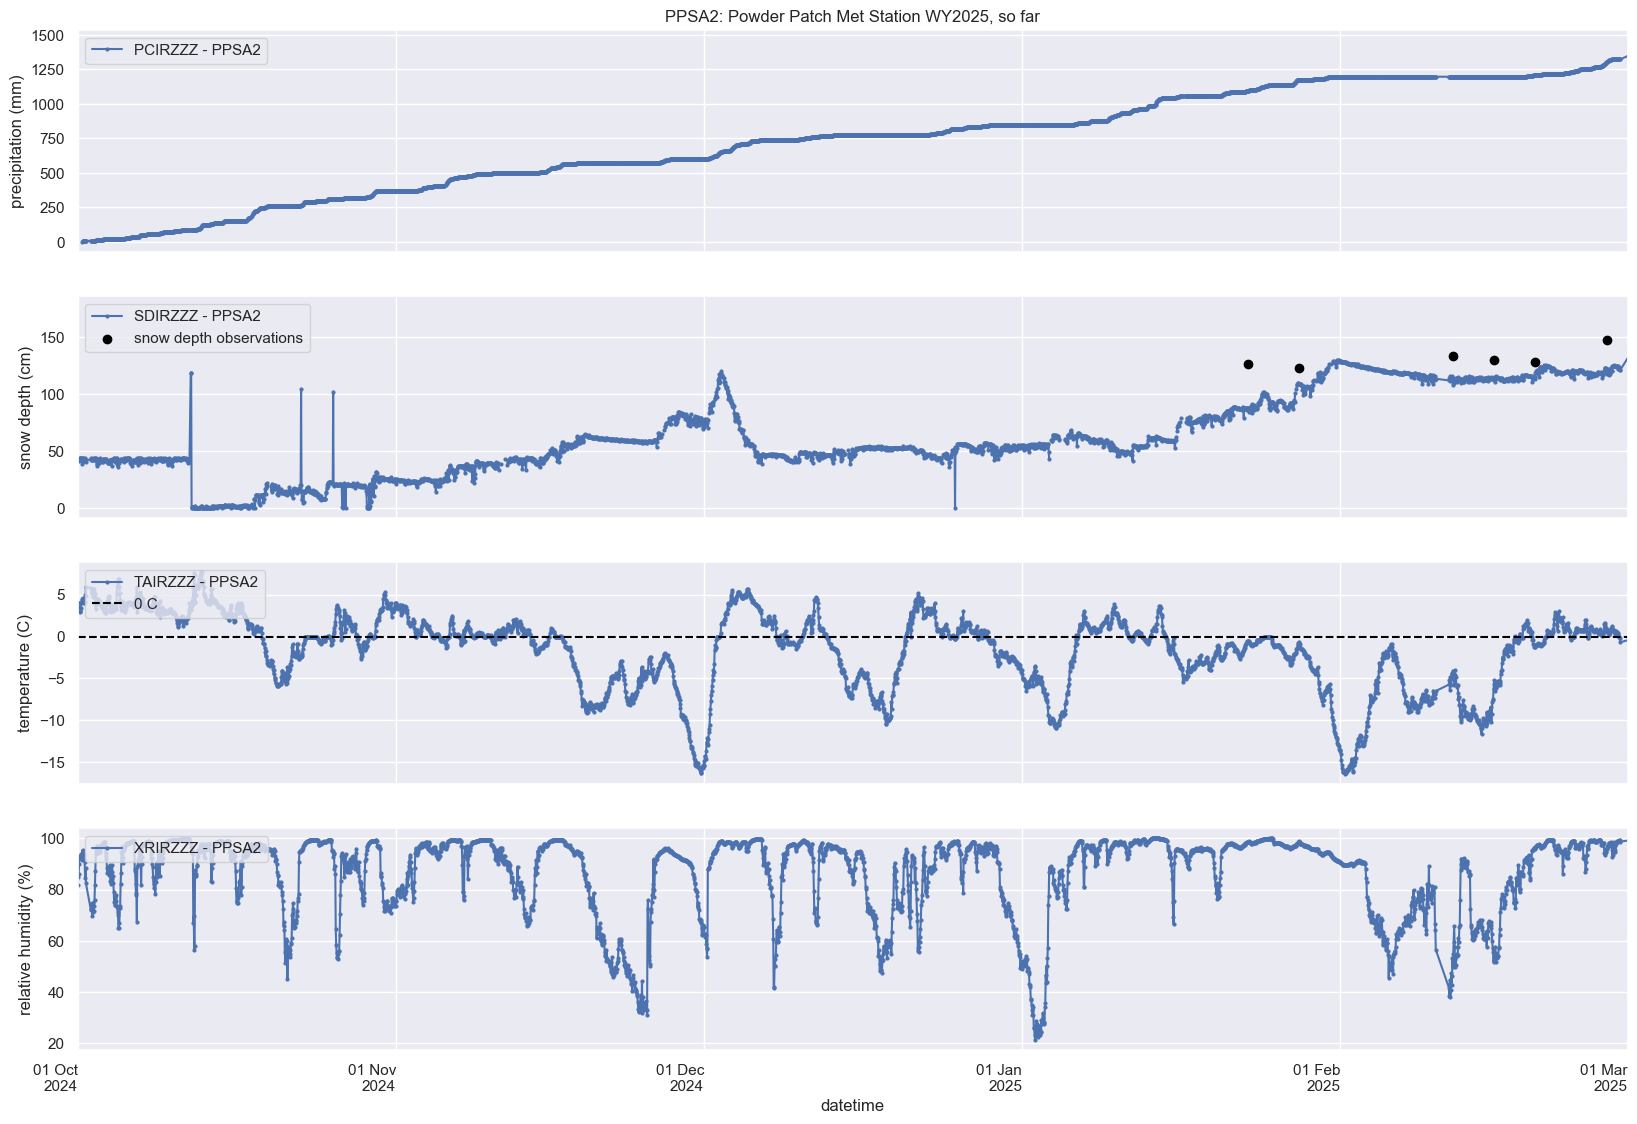

In [53]:
fig, ax = plt.subplots(4, 1, figsize=(20, 15), sharex=True)

ax[0].set_title('PPSA2: Powder Patch Met Station WY2025, so far')

# df_met_pp['PCIRZZZ'].plot(ax=ax[0],marker='o', markersize=2, label='PCIRZZZ - PPSA2') # inches 
# df_met_pp['SDIRZZZ'].plot(ax=ax[1],marker='o', markersize=2, label='SDIRZZZ - PPSA2') # in inches 
# df_met_pp['TAIRZZZ'].plot(ax=ax[2],marker='o', markersize=2, label='TAIRZZZ - PPSA2') # in F 

(df_met_pp['PCIRZZZ']*25.4).plot(ax=ax[0],marker='o', markersize=2, label='PCIRZZZ - PPSA2') # mm
(df_met_pp['SDIRZZZ']*2.54).plot(ax=ax[1],marker='o', markersize=2, label='SDIRZZZ - PPSA2') # in inches 
ax[1].scatter(df_obs.index, df_obs['snowdepth'], label='snow depth observations', color='black', marker='o') # add in the observations

((df_met_pp['TAIRZZZ'] - 32)*5.0/9.0).plot(ax=ax[2],marker='o', markersize=2, label='TAIRZZZ - PPSA2') # now in C
# add a zero line on air temperature 
ax[2].axhline(y=0, color='black', linestyle='--', label='0 C')

df_met_pp['XRIRZZZ'].plot(ax=ax[3],marker='o', markersize=2, label='XRIRZZZ - PPSA2')

# ax[0].set_ylabel('precipitation (in)')
# ax[2].set_ylabel('temperature (F)')
# ax[1].set_ylabel('snow depth (in)')

ax[0].set_ylabel('precipitation (mm)')
ax[1].set_ylabel('snow depth (cm)')
ax[2].set_ylabel('temperature (C)')
ax[3].set_ylabel('relative humidity (%)')
        
# Set common x-label for all subplots
ax[-1].set_xlabel('datetime')
# Set x-axis major formatter
ax[-1].xaxis.set_major_formatter(dates.DateFormatter('%d %b\n%Y')) #'%d %b\n%Y'
plt.setp(ax[-1].xaxis.get_majorticklabels(), rotation=360)

# show a legend on all subplots
loc = 'upper left'
ax[0].legend(loc=loc)
ax[1].legend(loc=loc)
ax[2].legend(loc=loc)
ax[3].legend(loc=loc)

# select daterange 
start_date = '2024-10-01'
end_date = '2025-03-01'
# Filter the x-axis to show only the specified date range
for a in ax:
    a.set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

plt.show()

## Now, add in the hrrr-ak timeseries

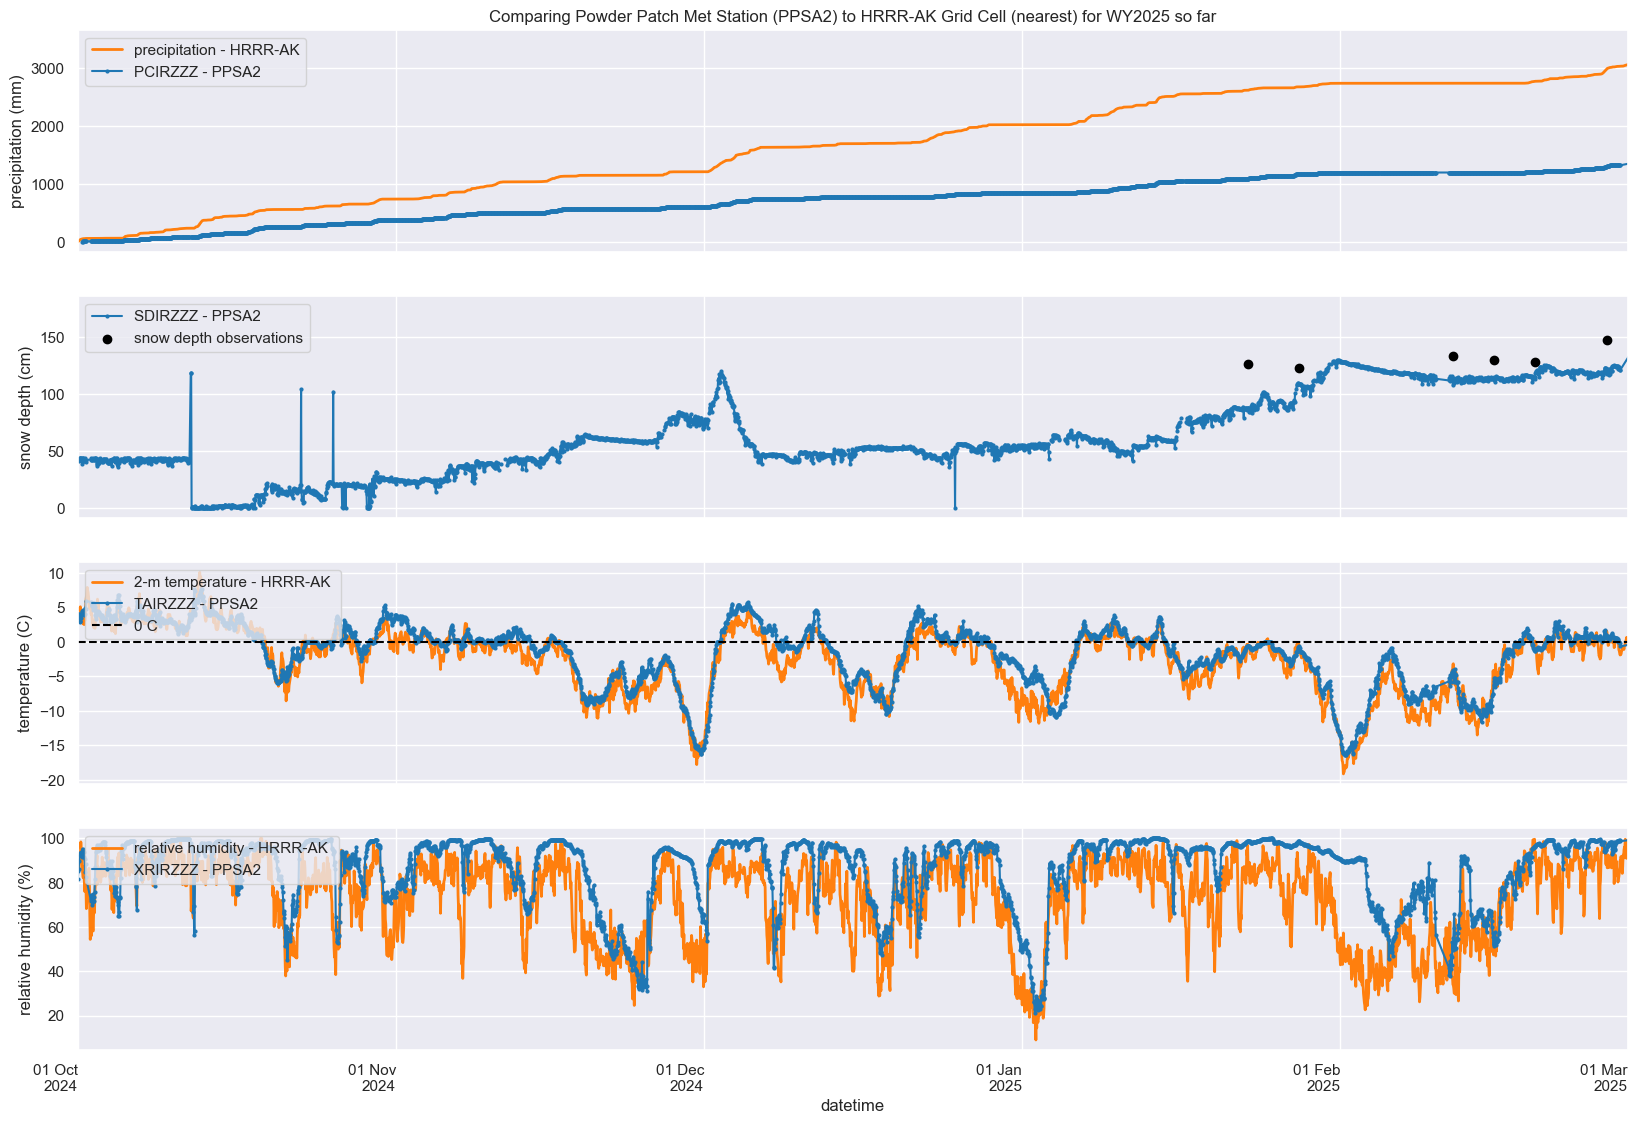

In [112]:
fig, ax = plt.subplots(4, 1, figsize=(20, 15), sharex=True)

# and add in the hrrr-ak variables which match 
ds_hrrrak_pp['precip_total'].cumsum().plot(ax=ax[0], linestyle='-', label='precipitation - HRRR-AK', linewidth=2, color='tab:orange')  # mm
# ds_hrrrak_pp['precip_rate'].cumsum().plot(ax=ax[0], linestyle='-', label='precipitation - HRRR-AK', linewidth=2, color='red')  # mm
# ds_hrrrak_pp['snowdepth'].cumsum().plot(ax=ax[1], linestyle='-', label='Snow Depth - HRRR-AK', linewidth=2, color='tab:orange')  # cm
(ds_hrrrak_pp['temp'] - 273.15).plot(ax=ax[2], linestyle='-', label='2-m temperature - HRRR-AK ', linewidth=2, color='tab:orange')  # convert K to C
# (ds_hrrrak_pp['temp_surface'] - 273.15).plot(ax=ax[2], linestyle='-', label='surface temperature - HRRR-AK', linewidth=2, color='red')  # convert K to C
ds_hrrrak_pp['rh'].plot(ax=ax[3], linestyle='-', label='relative humidity - HRRR-AK ', linewidth=2, color='tab:orange')  # %


# df_met_pp data 
(df_met_pp['PCIRZZZ']*25.4).plot(ax=ax[0],marker='o', markersize=2, label='PCIRZZZ - PPSA2', color='tab:blue') # mm
(df_met_pp['SDIRZZZ']*2.54).plot(ax=ax[1],marker='o', markersize=2, label='SDIRZZZ - PPSA2', color='tab:blue') # in inches 
((df_met_pp['TAIRZZZ'] - 32)*5.0/9.0).plot(ax=ax[2],marker='o', markersize=2, label='TAIRZZZ - PPSA2', color='tab:blue') # now in C
df_met_pp['XRIRZZZ'].plot(ax=ax[3],marker='o', markersize=2, label='XRIRZZZ - PPSA2', color='tab:blue')


# add plotting extra 
ax[1].scatter(df_obs.index, df_obs['snowdepth'], label='snow depth observations', color='black', marker='o') # add in the observations
ax[2].axhline(y=0, color='black', linestyle='--', label='0 C')

# Labels 
ax[0].set_title('Comparing Powder Patch Met Station (PPSA2) to HRRR-AK Grid Cell (nearest) for WY2025 so far')
ax[1].set_title('')
ax[2].set_title('')
ax[3].set_title('')

ax[0].set_ylabel('precipitation (mm)')
ax[1].set_ylabel('snow depth (cm)')
ax[2].set_ylabel('temperature (C)')
ax[3].set_ylabel('relative humidity (%)')
        
# Set common x-label for all subplots
ax[-1].set_xlabel('datetime')
ax[-1].xaxis.set_major_formatter(dates.DateFormatter('%d %b\n%Y')) #'%d %b\n%Y'
plt.setp(ax[-1].xaxis.get_majorticklabels(), rotation=360)

# select daterange 
start_date = '2024-10-01'
end_date = '2025-03-01'
# Filter the x-axis to show only the specified date range
for a in ax:
    a.set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

# show a legend on all subplots
loc = 'upper left'
ax[0].legend(loc=loc)
ax[1].legend(loc=loc)
ax[2].legend(loc=loc)
ax[3].legend(loc=loc)

plt.show()

Change the snow depth subplot to precipitation rate

In [113]:
df_met_pp

,station,utc_valid,PCIRZZZ,SDIRZZZ,TAIRZZZ,XRIRZZZ,PPIRZZZ
datetime,,,,,,,
2024-10-01 00:00:00,PPSA2,2024-10-01 00:00:00,NaN,16.97,39.2,81.60,NaN
2024-10-01 01:00:00,PPSA2,2024-10-01 01:00:00,NaN,16.58,39.3,85.10,NaN
2024-10-01 02:00:00,PPSA2,2024-10-01 02:00:00,NaN,16.88,39.3,86.20,NaN
2024-10-01 03:00:00,PPSA2,2024-10-01 03:00:00,NaN,16.18,38.3,90.00,NaN
2024-10-01 04:00:00,PPSA2,2024-10-01 04:00:00,NaN,17.19,37.5,92.30,NaN
...,...,...,...,...,...,...,...
2025-03-15 20:00:00,PPSA2,2025-03-15 20:00:00,57.52,NaN,19.0,81.30,0.0
2025-03-15 21:00:00,PPSA2,2025-03-15 21:00:00,57.52,NaN,20.2,79.62,0.0
2025-03-15 22:00:00,PPSA2,2025-03-15 22:00:00,57.52,NaN,20.2,82.40,0.0


Calculate preciptiation rate

In [114]:
df_met_pp['PPIRZZZ'] = df_met_pp['PCIRZZZ'].diff() # subtract the previus value to get the difference 

# then drop any values about 10 
df_met_pp['PPIRZZZ'] = df_met_pp['PPIRZZZ'].where(df_met_pp['PPIRZZZ'] < 1)
df_met_pp

,station,utc_valid,PCIRZZZ,SDIRZZZ,TAIRZZZ,XRIRZZZ,PPIRZZZ
datetime,,,,,,,
2024-10-01 00:00:00,PPSA2,2024-10-01 00:00:00,NaN,16.97,39.2,81.60,NaN
2024-10-01 01:00:00,PPSA2,2024-10-01 01:00:00,NaN,16.58,39.3,85.10,NaN
2024-10-01 02:00:00,PPSA2,2024-10-01 02:00:00,NaN,16.88,39.3,86.20,NaN
2024-10-01 03:00:00,PPSA2,2024-10-01 03:00:00,NaN,16.18,38.3,90.00,NaN
2024-10-01 04:00:00,PPSA2,2024-10-01 04:00:00,NaN,17.19,37.5,92.30,NaN
...,...,...,...,...,...,...,...
2025-03-15 20:00:00,PPSA2,2025-03-15 20:00:00,57.52,NaN,19.0,81.30,0.0
2025-03-15 21:00:00,PPSA2,2025-03-15 21:00:00,57.52,NaN,20.2,79.62,0.0
2025-03-15 22:00:00,PPSA2,2025-03-15 22:00:00,57.52,NaN,20.2,82.40,0.0


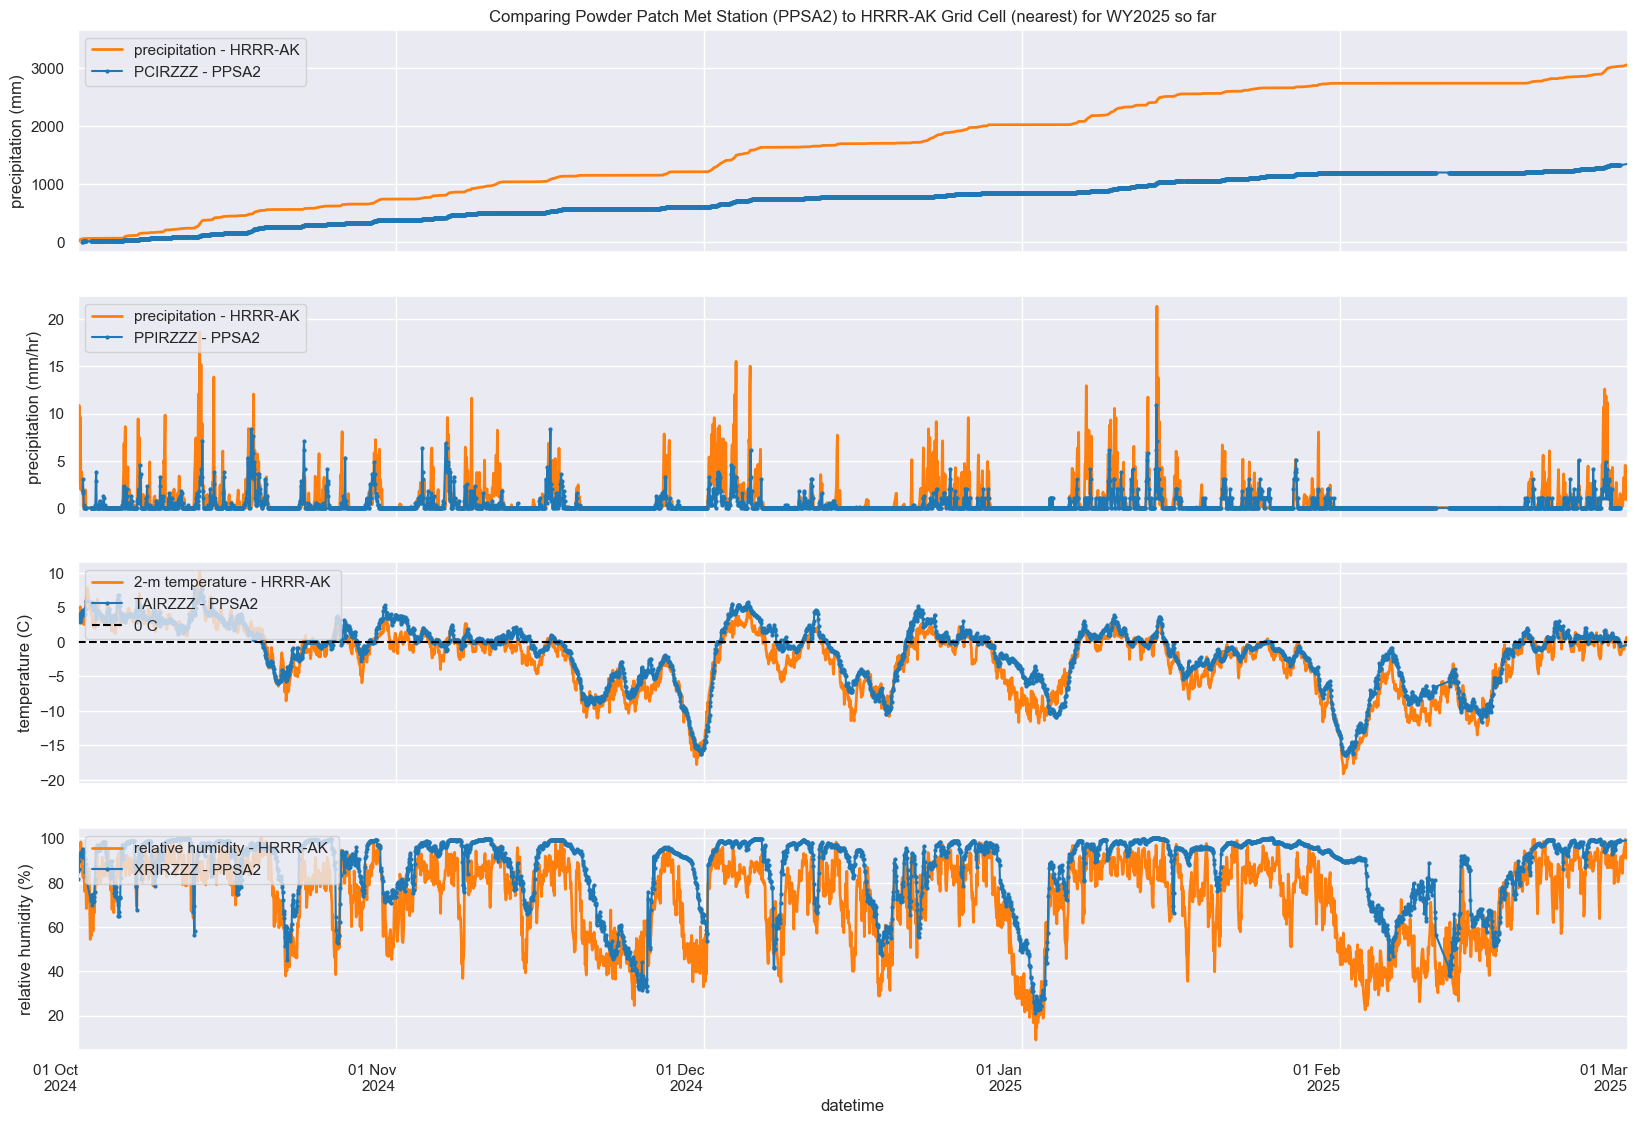

In [115]:
fig, ax = plt.subplots(4, 1, figsize=(20, 15), sharex=True)

# the hrrr-ak variables
ds_hrrrak_pp['precip_total'].cumsum().plot(ax=ax[0], linestyle='-', label='precipitation - HRRR-AK', linewidth=2, color='tab:orange')  # mm
ds_hrrrak_pp['precip_total'].plot(ax=ax[1], linestyle='-', label='precipitation - HRRR-AK', linewidth=2, color='tab:orange')  # mm
# ds_hrrrak_pp['precip_rate'].plot(ax=ax[1], linestyle='-', label='precipitation - HRRR-AK', linewidth=2, color='tab:orange')  # mm
(ds_hrrrak_pp['temp'] - 273.15).plot(ax=ax[2], linestyle='-', label='2-m temperature - HRRR-AK ', linewidth=2, color='tab:orange')  # convert K to C
# (ds_hrrrak_pp['temp_surface'] - 273.15).plot(ax=ax[2], linestyle='-', label='surface temperature - HRRR-AK', linewidth=2, color='tab:orange')  # convert K to C
ds_hrrrak_pp['rh'].plot(ax=ax[3], linestyle='-', label='relative humidity - HRRR-AK ', linewidth=2, color='tab:orange')  # %

# df_met_pp data 
(df_met_pp['PCIRZZZ']*25.4).plot(ax=ax[0],marker='o', markersize=2, label='PCIRZZZ - PPSA2', color='tab:blue') # now in mm 
(df_met_pp['PPIRZZZ']*25.4).plot(ax=ax[1],marker='o', markersize=2, label='PPIRZZZ - PPSA2', color='tab:blue') # now in mm 
((df_met_pp['TAIRZZZ'] - 32)*5.0/9.0).plot(ax=ax[2],marker='o', markersize=2, label='TAIRZZZ - PPSA2', color='tab:blue') # now in C
df_met_pp['XRIRZZZ'].plot(ax=ax[3],marker='o', markersize=2, label='XRIRZZZ - PPSA2', color='tab:blue')

# add plotting extra 
ax[2].axhline(y=0, color='black', linestyle='--', label='0 C')

# Labels 
ax[0].set_title('Comparing Powder Patch Met Station (PPSA2) to HRRR-AK Grid Cell (nearest) for WY2025 so far')
ax[1].set_title('')
ax[2].set_title('')
ax[3].set_title('')

ax[0].set_ylabel('precipitation (mm)')
ax[1].set_ylabel('precipitation (mm/hr)')
ax[2].set_ylabel('temperature (C)')
ax[3].set_ylabel('relative humidity (%)')
        
# Set common x-label for all subplots
ax[-1].set_xlabel('datetime')
ax[-1].xaxis.set_major_formatter(dates.DateFormatter('%d %b\n%Y')) #'%d %b\n%Y'
plt.setp(ax[-1].xaxis.get_majorticklabels(), rotation=360)

# select daterange 
start_date = '2024-10-01'
end_date = '2025-03-01'
# Filter the x-axis to show only the specified date range
for a in ax:
    a.set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

# show a legend on all subplots
loc = 'upper left'
ax[0].legend(loc=loc)
ax[1].legend(loc=loc)
ax[2].legend(loc=loc)
ax[3].legend(loc=loc)

# ax[1].set_ylim(-0.1,5)

plt.show()

Now, let's plot all of the useful HRRR-AK variables at the Powder Patch location

In [116]:
ds_hrrrak_pp

<xarray.Dataset> Size: 367kB
Dimensions:       (time: 4368)
Coordinates:
  * time          (time) datetime64[ns] 35kB 2024-10-01T01:00:00 ... 2025-04-01
    step          (time) timedelta64[ns] 35kB ...
    valid_time    (time) datetime64[ns] 35kB 2024-10-01T01:00:00 ... 2025-04-01
    latitude      float64 8B ...
    longitude     float64 8B -133.9
    y             float64 8B 58.27
    x             float64 8B -133.9
    spatial_ref   int64 8B 0
Data variables: (12/15)
    temp_surface  (time) float32 17kB ...
    pressure      (time) float32 17kB ...
    precip_rate   (time) float32 17kB ...
    snowdepth     (time) float32 17kB ...
    orog          (time) float32 17kB 654.6 654.6 654.6 ... 654.6 654.6 654.6
    precip_total  (time) float32 17kB 3.932 7.345 10.86 2.502 ... 0.0 0.0 0.0
    ...            ...
    lwrad         (time) float32 17kB ...
    temp          (time) float32 17kB 278.0 277.8 277.9 ... 273.8 274.1 274.3
    rh            (time) float32 17kB ...
    u10           (time) float32 17kB ...
    v10           (time) float32 17kB ...
    wind          (time) float32 17kB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP

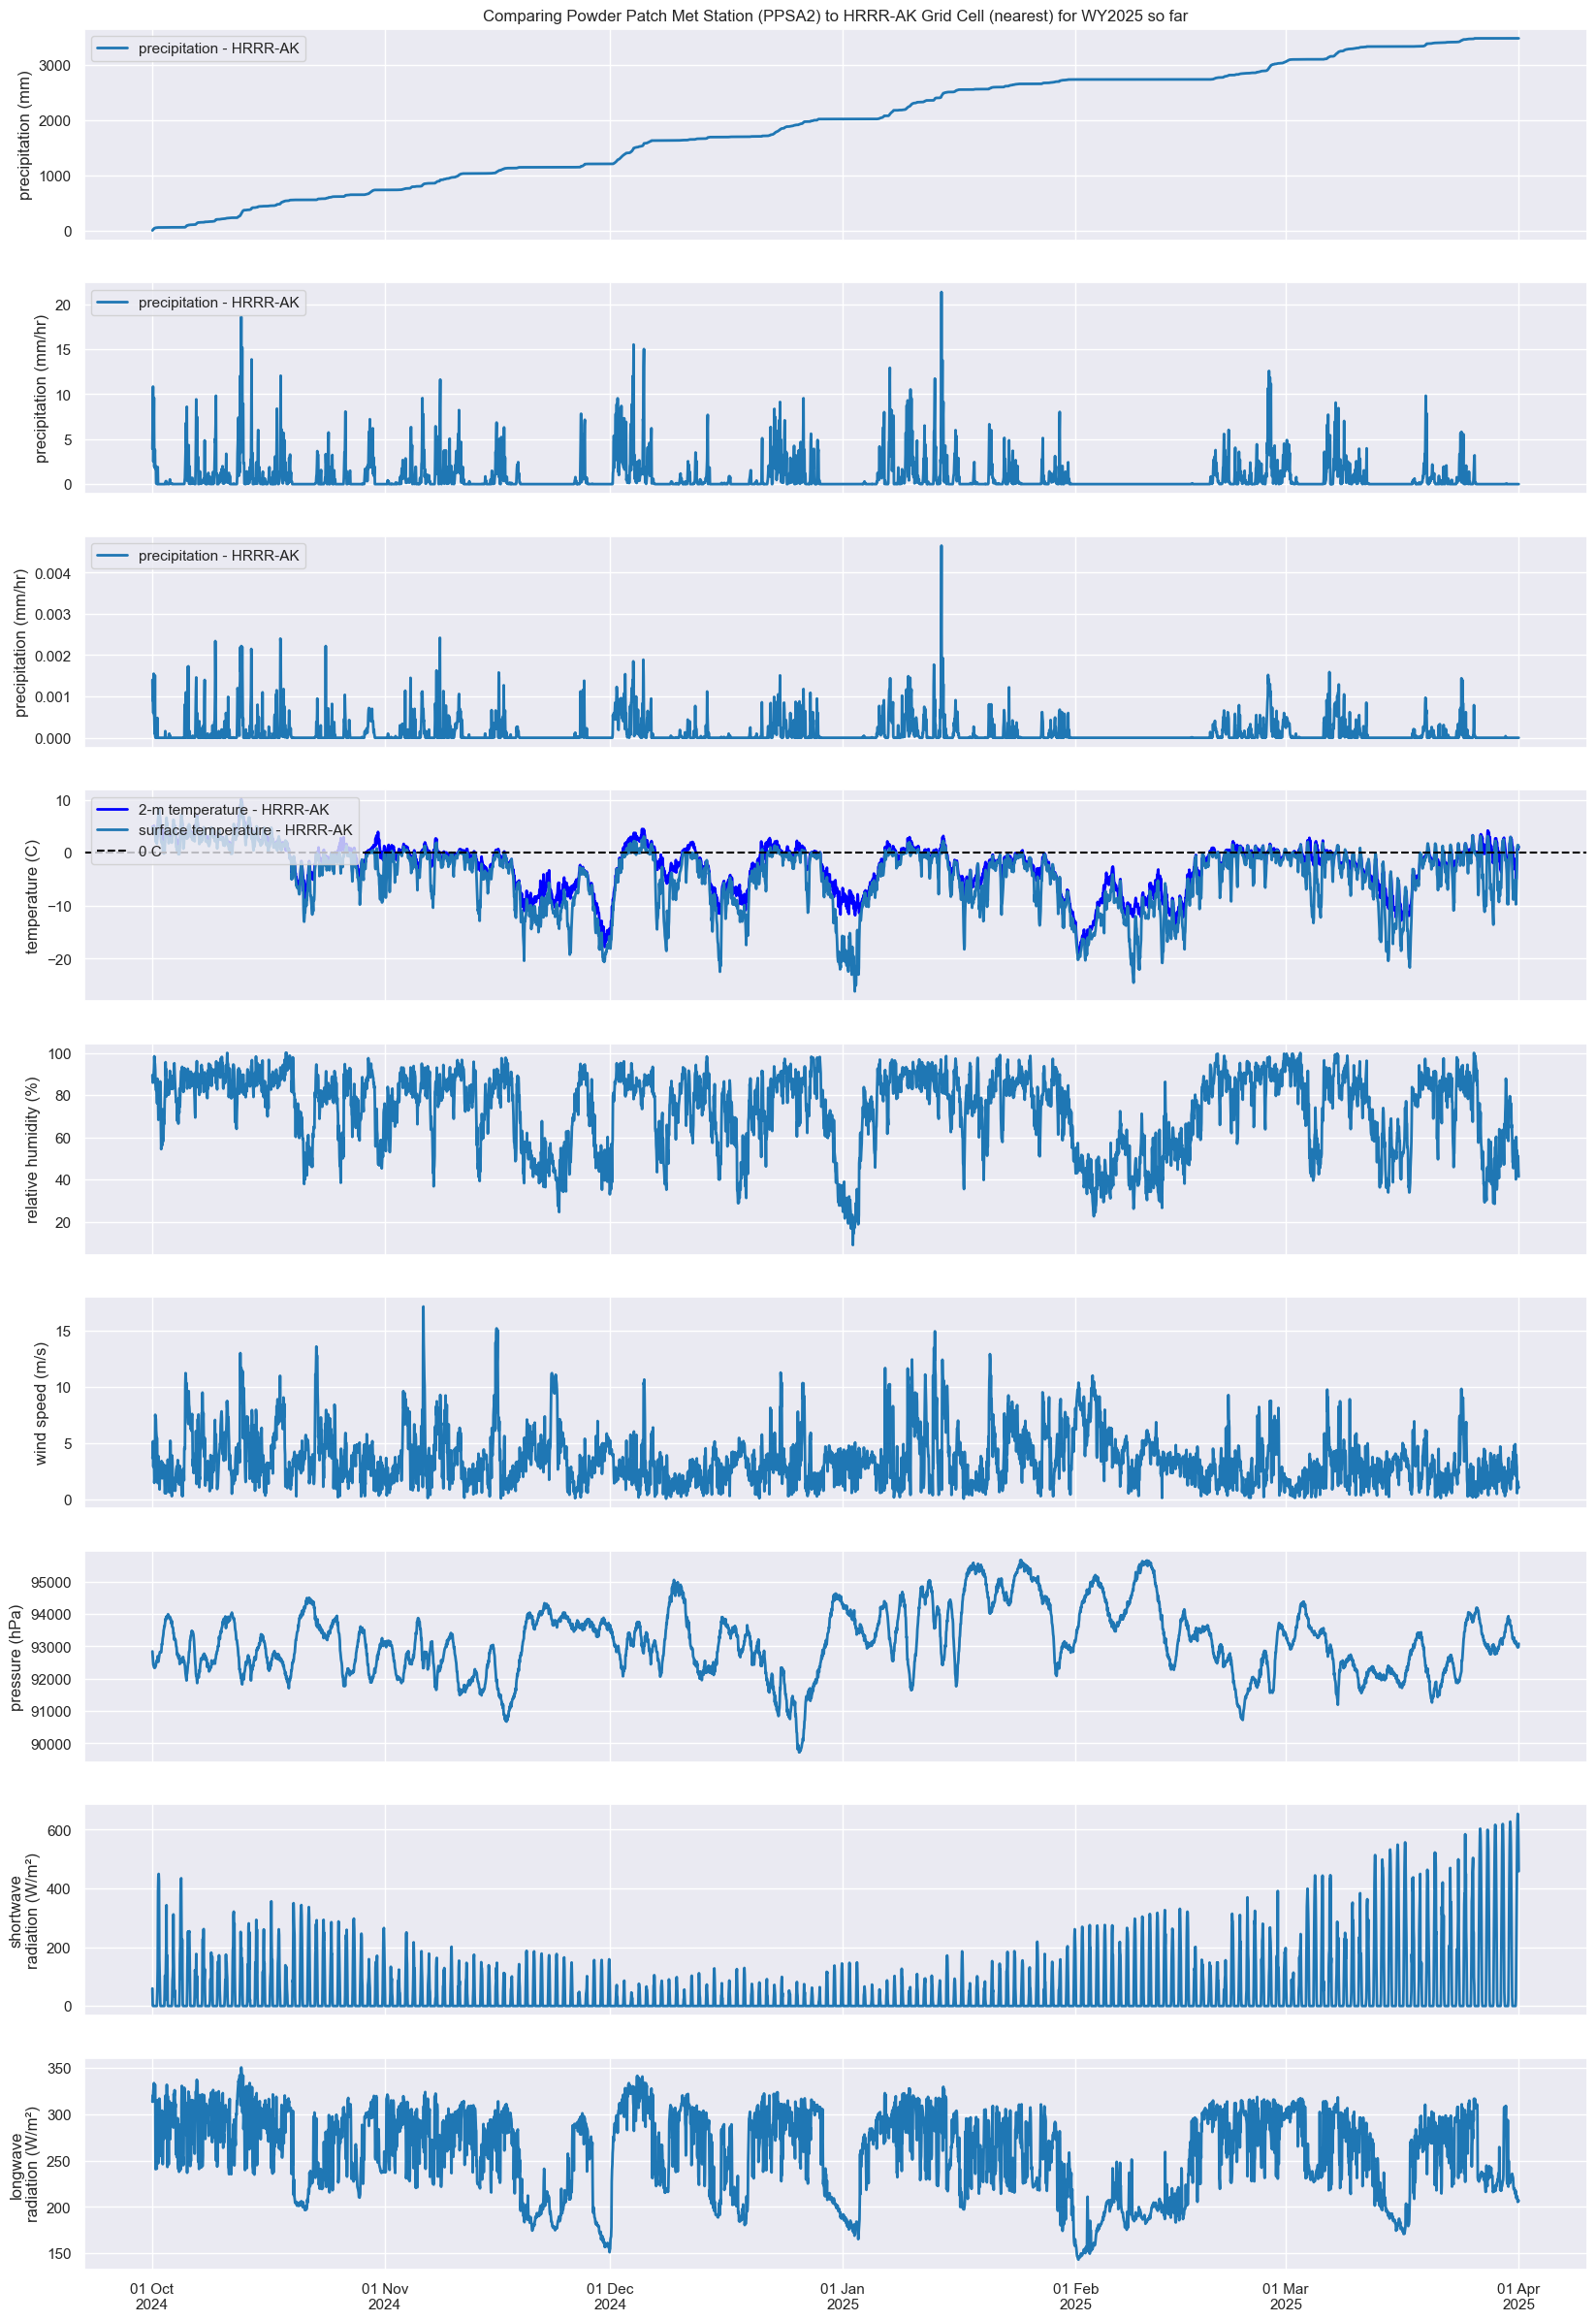

In [117]:
fig, ax = plt.subplots(9, 1, figsize=(20, 30), sharex=True)

# the hrrr-ak variables
ds_hrrrak_pp['precip_total'].cumsum().plot(ax=ax[0], linestyle='-', label='precipitation - HRRR-AK', linewidth=2, color='tab:blue')  # mm
ds_hrrrak_pp['precip_total'].plot(ax=ax[1], linestyle='-', label='precipitation - HRRR-AK', linewidth=2, color='tab:blue')  # mm
ds_hrrrak_pp['precip_rate'].plot(ax=ax[2], linestyle='-', label='precipitation - HRRR-AK', linewidth=2, color='tab:blue')  # mm

(ds_hrrrak_pp['temp'] - 273.15).plot(ax=ax[3], linestyle='-', label='2-m temperature - HRRR-AK ', linewidth=2, color='blue')  # convert K to C
(ds_hrrrak_pp['temp_surface'] - 273.15).plot(ax=ax[3], linestyle='-', label='surface temperature - HRRR-AK', linewidth=2, color='tab:blue')  # convert K to C

ds_hrrrak_pp['rh'].plot(ax=ax[4], linestyle='-', label='relative humidity - HRRR-AK ', linewidth=2, color='tab:blue')  # %
ds_hrrrak_pp['wind'].plot(ax=ax[5], linestyle='-', label='10-m wind speed - HRRR-AK', linewidth=2, color='tab:blue')  # m/s
ds_hrrrak_pp['pressure'].plot(ax=ax[6], linestyle='-', label='surface pressure - HRRR-AK', linewidth=2, color='tab:blue')  # hPa
ds_hrrrak_pp['swrad'].plot(ax=ax[7], linestyle='-', label='surface shortwave radiation - HRRR-AK', linewidth=2, color='tab:blue')  # W/m^2
ds_hrrrak_pp['lwrad'].plot(ax=ax[8], linestyle='-', label='surface longwave radiation - HRRR-AK', linewidth=2, color='tab:blue')  # W/m^2


# add plotting extra 
ax[3].axhline(y=0, color='black', linestyle='--', label='0 C')

# Labels 
ax[0].set_ylabel('precipitation (mm)')
ax[1].set_ylabel('precipitation (mm/hr)')
ax[2].set_ylabel('precipitation (mm/hr)')
ax[3].set_ylabel('temperature (C)')
ax[4].set_ylabel('relative humidity (%)')
ax[5].set_ylabel('wind speed (m/s)')
ax[6].set_ylabel('pressure (hPa)')
ax[7].set_ylabel('shortwave\nradiation (W/m²)')
ax[8].set_ylabel('longwave\nradiation (W/m²)')
        
# Set common x-label for all subplots
ax[-1].set_xlabel('datetime')
ax[-1].xaxis.set_major_formatter(dates.DateFormatter('%d %b\n%Y')) #'%d %b\n%Y'
plt.setp(ax[-1].xaxis.get_majorticklabels(), rotation=360)

# # select daterange 
# start_date = '2024-10-01'
# end_date = '2025-03-01'
# # Filter the x-axis to show only the specified date range
# for a in ax:
#     a.set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

# show a legend on all subplots

loc = 'upper left'
ax[0].legend(loc=loc)
ax[1].legend(loc=loc)
ax[2].legend(loc=loc)
ax[3].legend(loc=loc)

# remove all the titles and x labels on the subplots 
for i in range(0, 9):
    ax[i].set_title('')
    ax[i].set_xlabel('')
    
ax[0].set_title('Comparing Powder Patch Met Station (PPSA2) to HRRR-AK Grid Cell (nearest) for WY2025 so far')

plt.show()

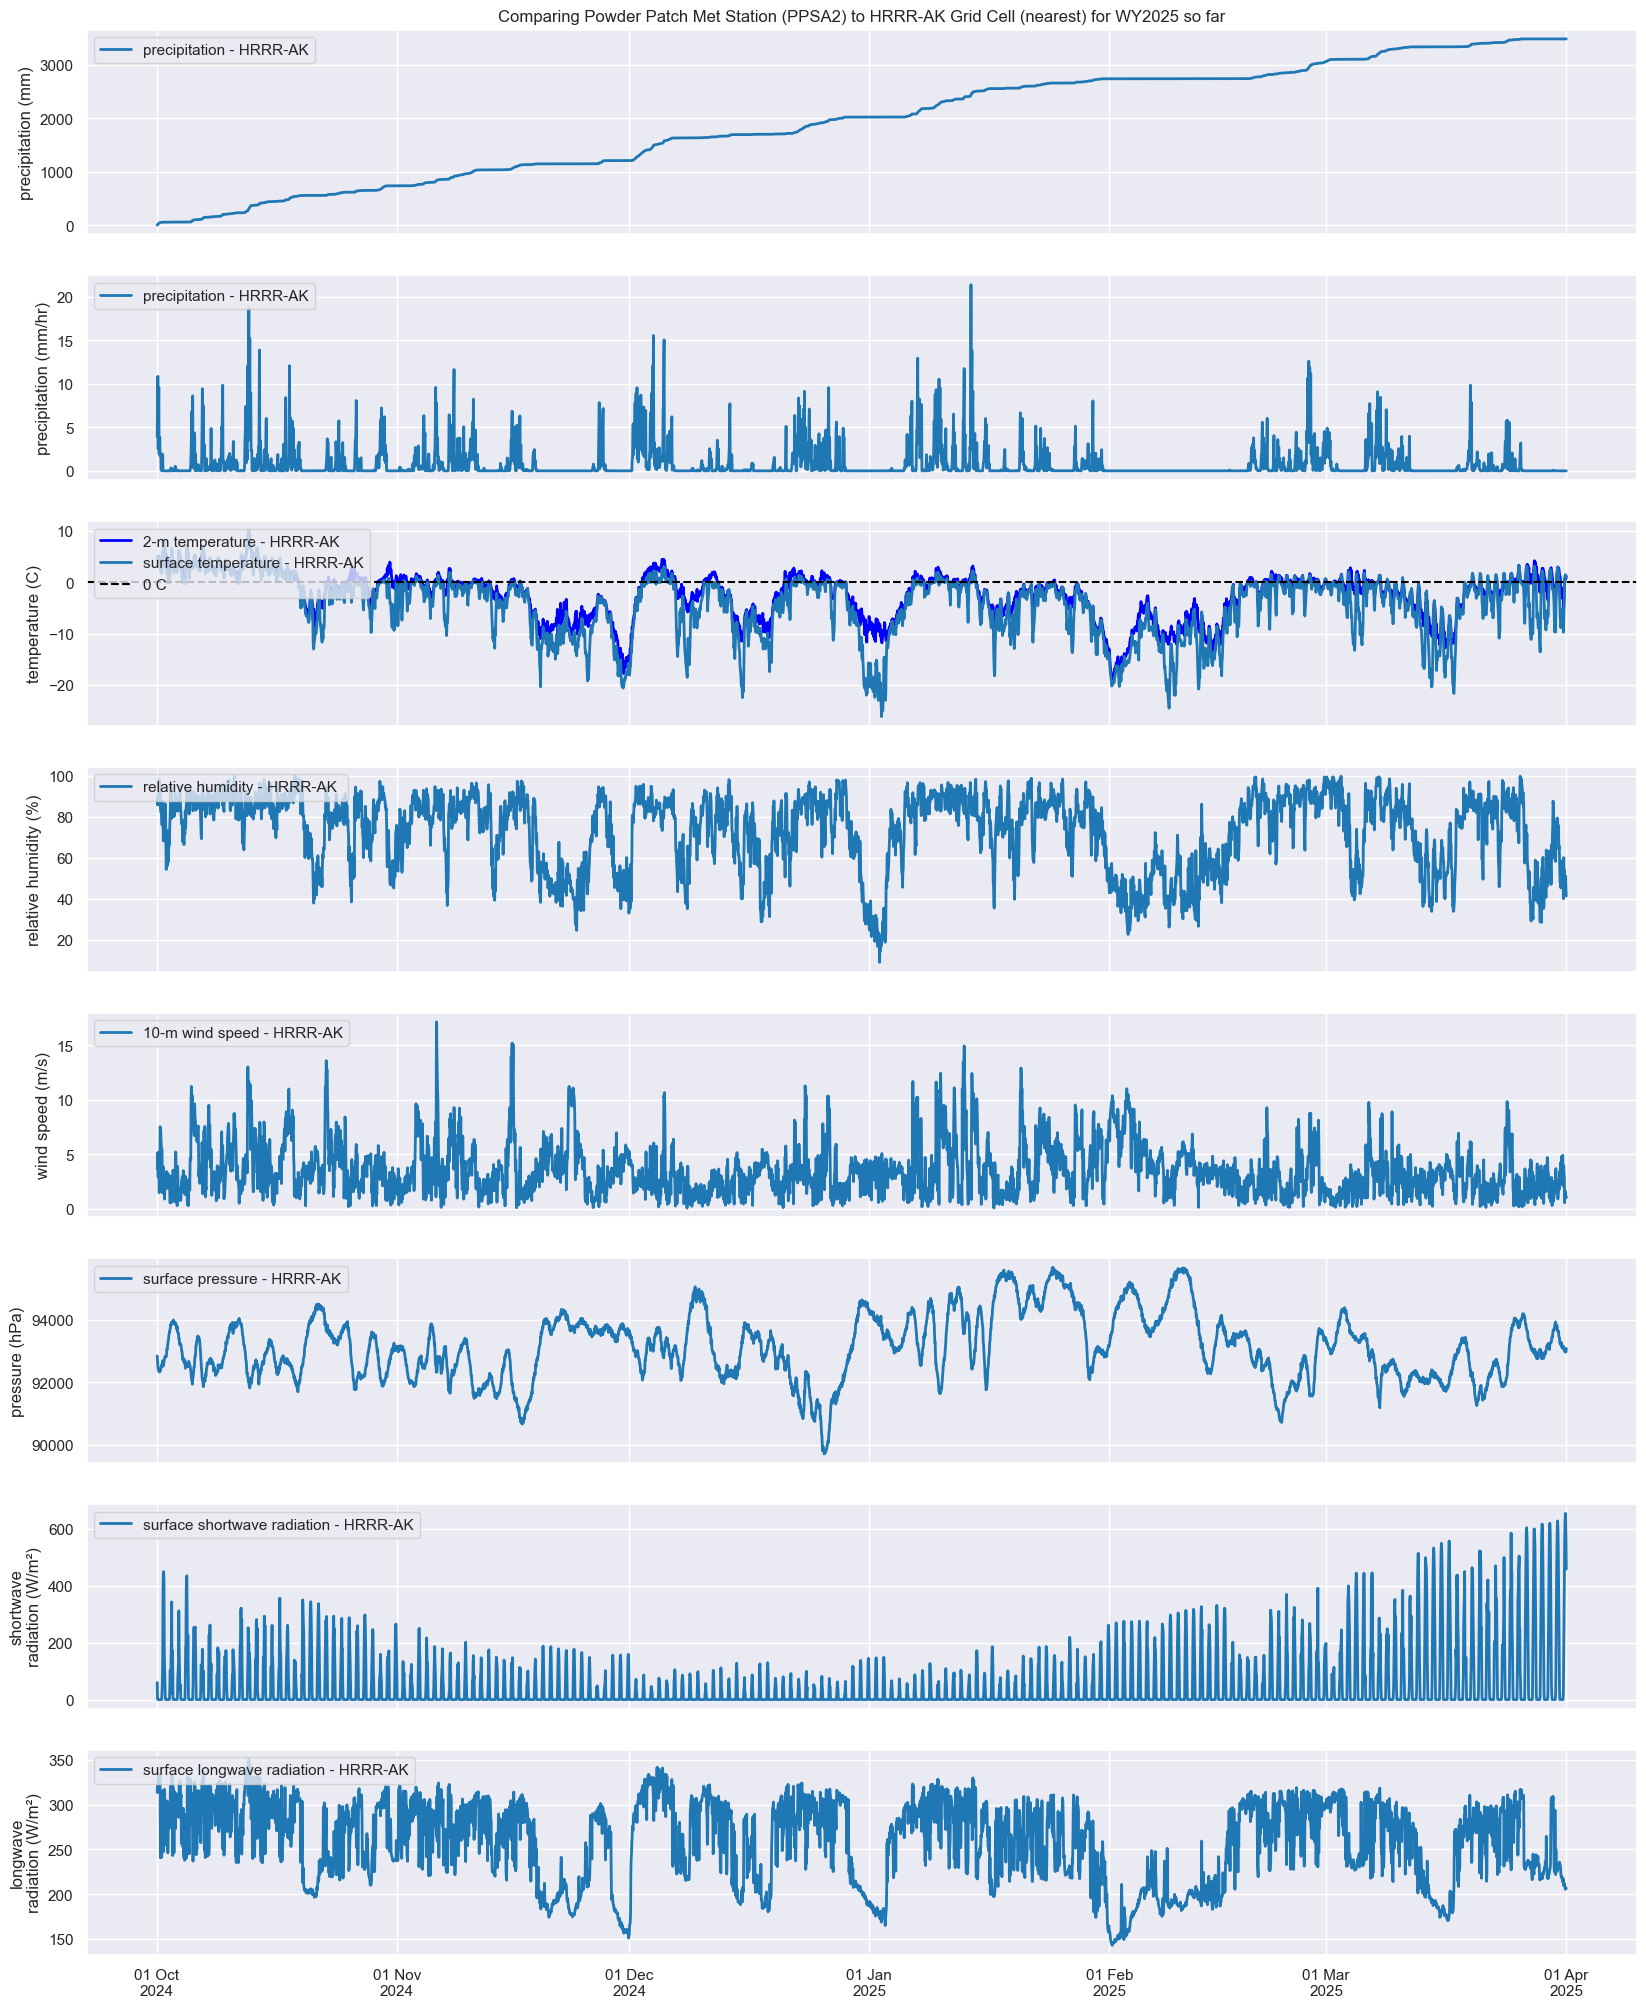

In [118]:
fig, ax = plt.subplots(8, 1, figsize=(20, 25), sharex=True)

# the hrrr-ak variables
ds_hrrrak_pp['precip_total'].cumsum().plot(ax=ax[0], linestyle='-', label='precipitation - HRRR-AK', linewidth=2, color='tab:blue')  # mm
ds_hrrrak_pp['precip_total'].plot(ax=ax[1], linestyle='-', label='precipitation - HRRR-AK', linewidth=2, color='tab:blue')  # mm
# ds_hrrrak_pp['precip_rate'].plot(ax=ax[2], linestyle='-', label='precipitation - HRRR-AK', linewidth=2, color='tab:blue')  # mm

(ds_hrrrak_pp['temp'] - 273.15).plot(ax=ax[2], linestyle='-', label='2-m temperature - HRRR-AK ', linewidth=2, color='blue')  # convert K to C
(ds_hrrrak_pp['temp_surface'] - 273.15).plot(ax=ax[2], linestyle='-', label='surface temperature - HRRR-AK', linewidth=2, color='tab:blue')  # convert K to C

ds_hrrrak_pp['rh'].plot(ax=ax[3], linestyle='-', label='relative humidity - HRRR-AK ', linewidth=2, color='tab:blue')  # %
ds_hrrrak_pp['wind'].plot(ax=ax[4], linestyle='-', label='10-m wind speed - HRRR-AK', linewidth=2, color='tab:blue')  # m/s
ds_hrrrak_pp['pressure'].plot(ax=ax[5], linestyle='-', label='surface pressure - HRRR-AK', linewidth=2, color='tab:blue')  # hPa
ds_hrrrak_pp['swrad'].plot(ax=ax[6], linestyle='-', label='surface shortwave radiation - HRRR-AK', linewidth=2, color='tab:blue')  # W/m^2
ds_hrrrak_pp['lwrad'].plot(ax=ax[7], linestyle='-', label='surface longwave radiation - HRRR-AK', linewidth=2, color='tab:blue')  # W/m^2

# add plotting extra 
ax[2].axhline(y=0, color='black', linestyle='--', label='0 C')

# Labels 
ax[0].set_ylabel('precipitation (mm)')
ax[1].set_ylabel('precipitation (mm/hr)')
# ax[2].set_ylabel('precipitation (mm/hr)')
ax[2].set_ylabel('temperature (C)')
ax[3].set_ylabel('relative humidity (%)')
ax[4].set_ylabel('wind speed (m/s)')
ax[5].set_ylabel('pressure (hPa)')
ax[6].set_ylabel('shortwave\nradiation (W/m²)')
ax[7].set_ylabel('longwave\nradiation (W/m²)')
        
# Set common x-label for all subplots
ax[-1].set_xlabel('datetime')
ax[-1].xaxis.set_major_formatter(dates.DateFormatter('%d %b\n%Y')) #'%d %b\n%Y'
plt.setp(ax[-1].xaxis.get_majorticklabels(), rotation=360)

# # select daterange 
# start_date = '2024-10-01'
# end_date = '2025-03-01'
# # Filter the x-axis to show only the specified date range
# for a in ax:
#     a.set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

# add a legend on all subplots
loc = 'upper left'
ax[0].legend(loc=loc)
ax[1].legend(loc=loc)
ax[2].legend(loc=loc)
ax[3].legend(loc=loc)
ax[4].legend(loc=loc)
ax[5].legend(loc=loc)
ax[6].legend(loc=loc)
ax[7].legend(loc=loc)

# remove all the titles and x labels on the subplots 
for i in range(0, 8):
    ax[i].set_title('')
    ax[i].set_xlabel('')
    
ax[0].set_title('Comparing Powder Patch Met Station (PPSA2) to HRRR-AK Grid Cell (nearest) for WY2025 so far')

plt.show()

Zoom into a daterange just to check it out...

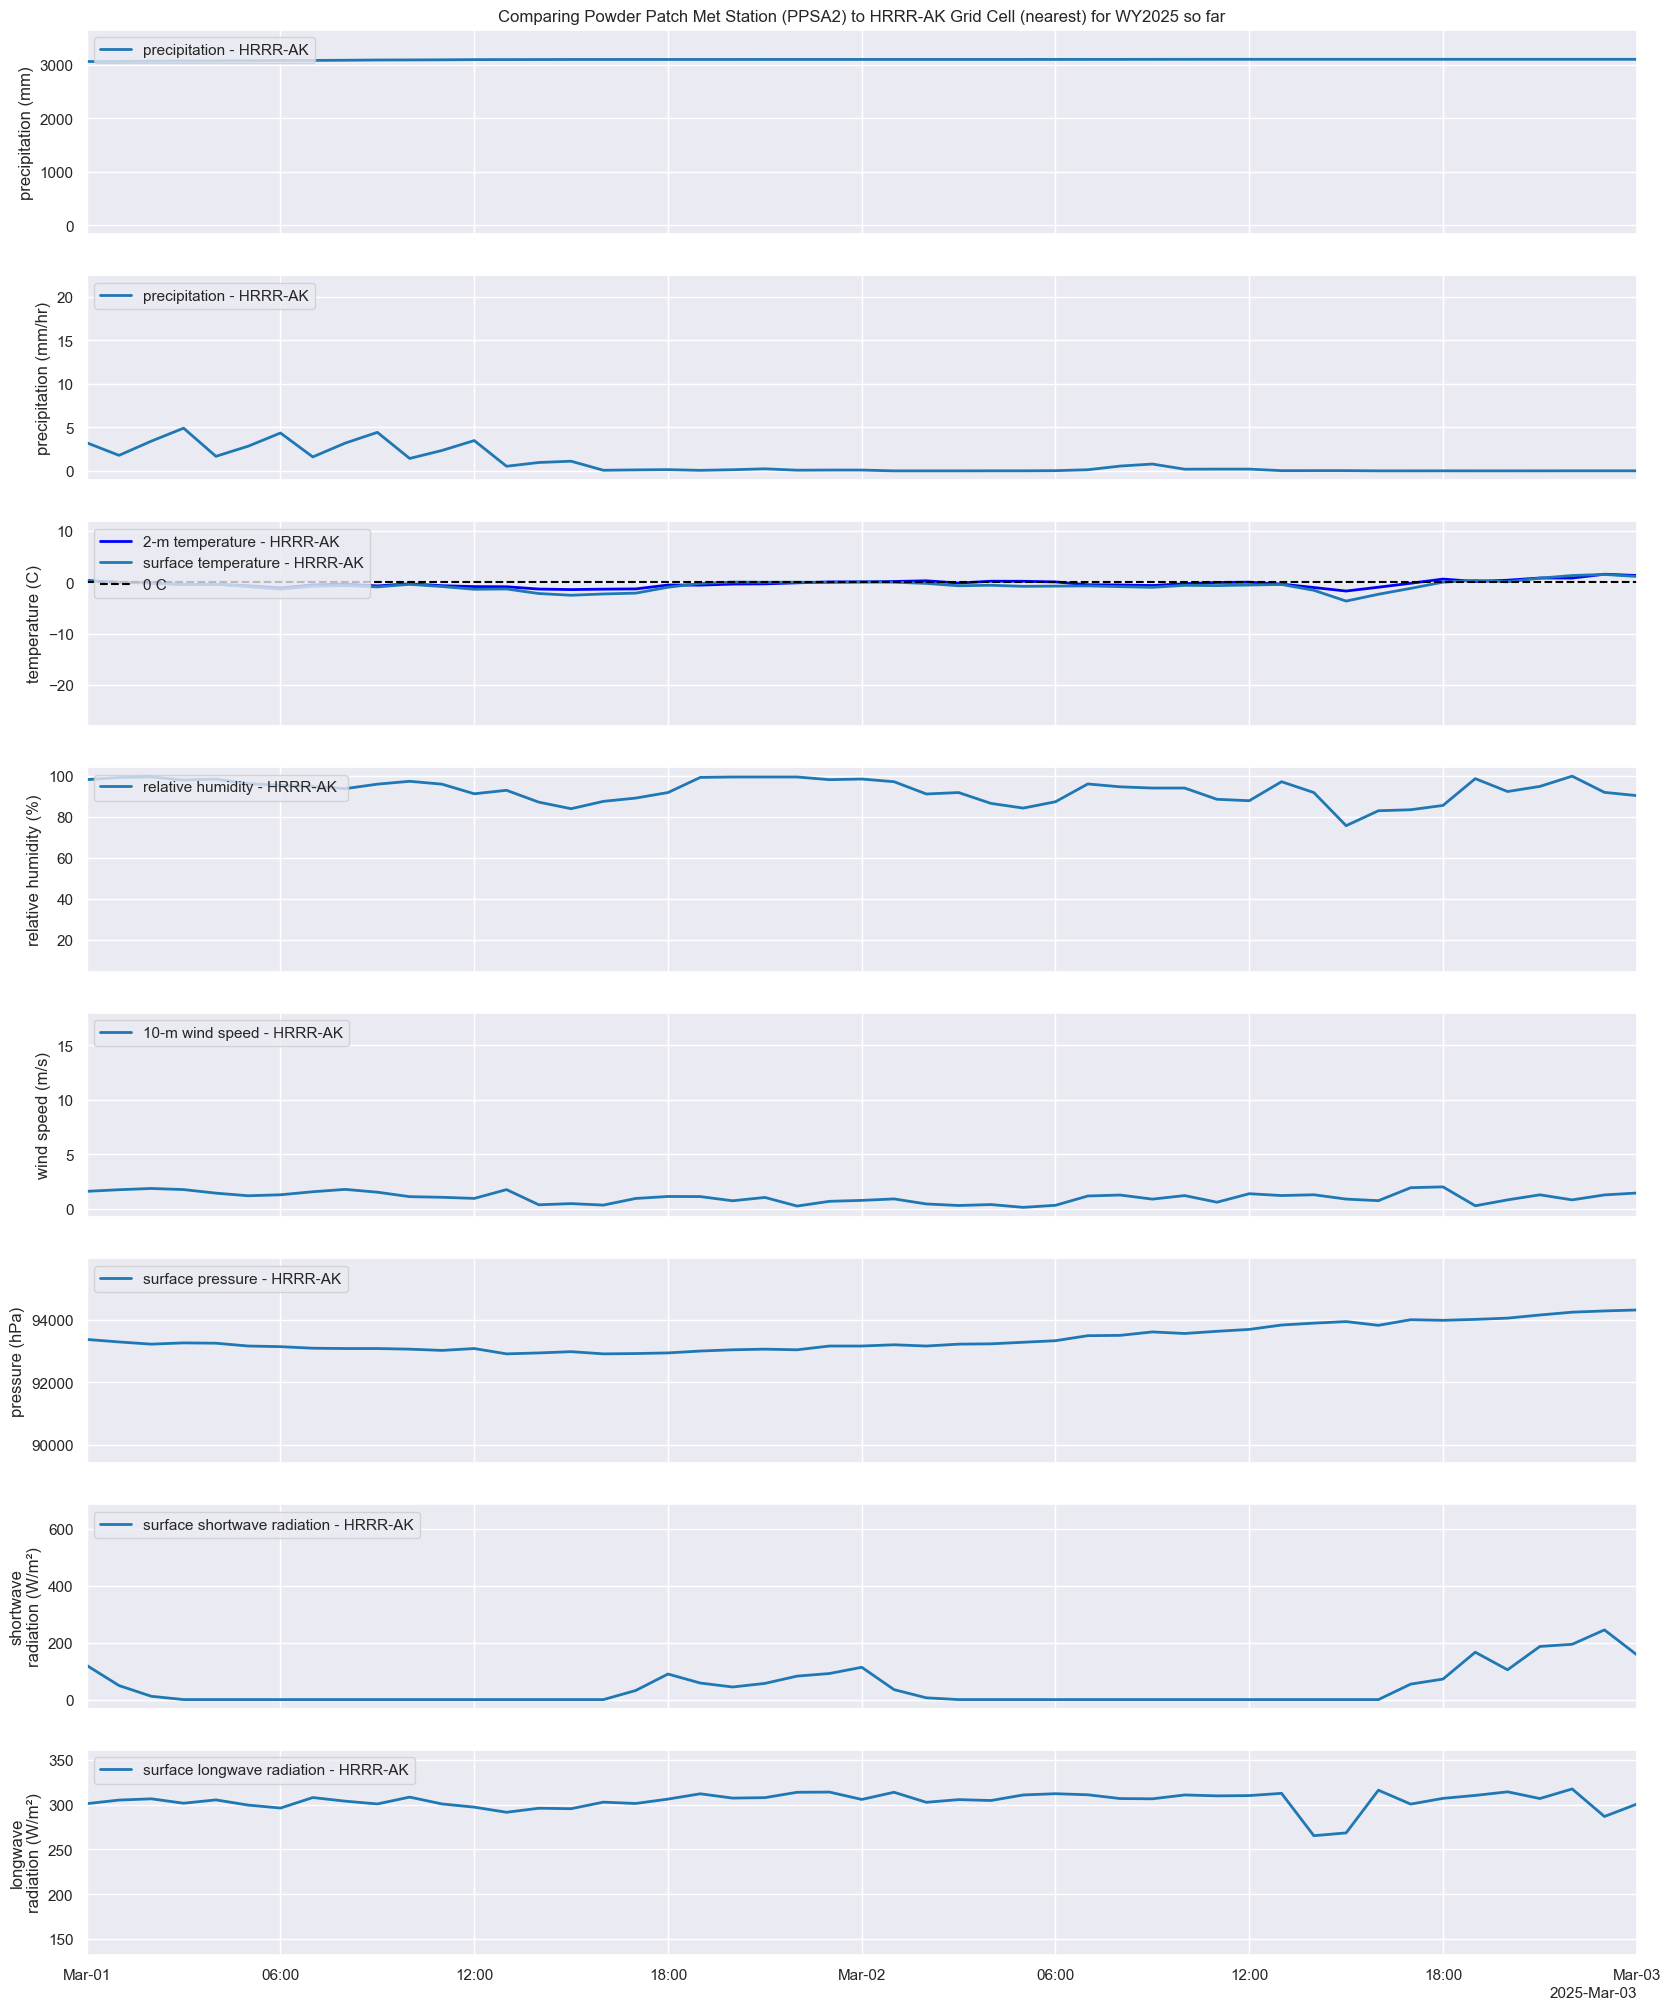

In [119]:
fig, ax = plt.subplots(8, 1, figsize=(20, 25), sharex=True)

# the hrrr-ak variables
ds_hrrrak_pp['precip_total'].cumsum().plot(ax=ax[0], linestyle='-', label='precipitation - HRRR-AK', linewidth=2, color='tab:blue')  # mm
ds_hrrrak_pp['precip_total'].plot(ax=ax[1], linestyle='-', label='precipitation - HRRR-AK', linewidth=2, color='tab:blue')  # mm
# ds_hrrrak_pp['precip_rate'].plot(ax=ax[2], linestyle='-', label='precipitation - HRRR-AK', linewidth=2, color='tab:blue')  # mm

(ds_hrrrak_pp['temp'] - 273.15).plot(ax=ax[2], linestyle='-', label='2-m temperature - HRRR-AK ', linewidth=2, color='blue')  # convert K to C
(ds_hrrrak_pp['temp_surface'] - 273.15).plot(ax=ax[2], linestyle='-', label='surface temperature - HRRR-AK', linewidth=2, color='tab:blue')  # convert K to C

ds_hrrrak_pp['rh'].plot(ax=ax[3], linestyle='-', label='relative humidity - HRRR-AK ', linewidth=2, color='tab:blue')  # %
ds_hrrrak_pp['wind'].plot(ax=ax[4], linestyle='-', label='10-m wind speed - HRRR-AK', linewidth=2, color='tab:blue')  # m/s
ds_hrrrak_pp['pressure'].plot(ax=ax[5], linestyle='-', label='surface pressure - HRRR-AK', linewidth=2, color='tab:blue')  # hPa
ds_hrrrak_pp['swrad'].plot(ax=ax[6], linestyle='-', label='surface shortwave radiation - HRRR-AK', linewidth=2, color='tab:blue')  # W/m^2
ds_hrrrak_pp['lwrad'].plot(ax=ax[7], linestyle='-', label='surface longwave radiation - HRRR-AK', linewidth=2, color='tab:blue')  # W/m^2

# add plotting extra 
ax[2].axhline(y=0, color='black', linestyle='--', label='0 C')

# Labels 
ax[0].set_ylabel('precipitation (mm)')
ax[1].set_ylabel('precipitation (mm/hr)')
# ax[2].set_ylabel('precipitation (mm/hr)')
ax[2].set_ylabel('temperature (C)')
ax[3].set_ylabel('relative humidity (%)')
ax[4].set_ylabel('wind speed (m/s)')
ax[5].set_ylabel('pressure (hPa)')
ax[6].set_ylabel('shortwave\nradiation (W/m²)')
ax[7].set_ylabel('longwave\nradiation (W/m²)')
        
# Set common x-label for all subplots
ax[-1].set_xlabel('datetime')
# ax[-1].xaxis.set_major_formatter(dates.DateFormatter('%d %b\n%Y')) #'%d %b\n%Y'
# plt.setp(ax[-1].xaxis.get_majorticklabels(), rotation=360)

# select daterange 
start_date = '2025-03-01'
end_date = '2025-03-03'
# Filter the x-axis to show only the specified date range
for a in ax:
    a.set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

# add a legend on all subplots
loc = 'upper left'
ax[0].legend(loc=loc)
ax[1].legend(loc=loc)
ax[2].legend(loc=loc)
ax[3].legend(loc=loc)
ax[4].legend(loc=loc)
ax[5].legend(loc=loc)
ax[6].legend(loc=loc)
ax[7].legend(loc=loc)

# remove all the titles and x labels on the subplots 
for i in range(0, 8):
    ax[i].set_title('')
    ax[i].set_xlabel('')
    
ax[0].set_title('Comparing Powder Patch Met Station (PPSA2) to HRRR-AK Grid Cell (nearest) for WY2025 so far')

plt.show()